In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot

import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [2]:
import sys
import logging
import datetime

nblog = open("./logs/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
%%time
df_localness = pd.read_csv('./data/food_localness_final_oct.csv')
print('unique orders:',df_localness.shape[0])
print('unique accounts:',df_localness.account_id.unique().shape[0])
df_localness.head(2)

unique orders: 2767286
unique accounts: 555121
CPU times: user 21.4 s, sys: 2.74 s, total: 24.1 s
Wall time: 26.9 s


,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,node_id,nearest_dist1,poi1,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,vendor_index,pandana_distance_realdist,pandana_localness,speed,isweekend,price_per_item,customer_loc_id,entropy_0.5km,restaurant_count_0.5km,entropy_1km,poi_count_1km,entropy_2km,poi_count_2km,entropy_3km,poi_count_3km,entropy_4km,poi_count_4km,entropy_5km,poi_count_5km,restaurant_count_0.5_1km,restaurant_count_1_2km,restaurant_count_2_3km,restaurant_count_3_4km,restaurant_count_4_5km,estimated_rent,compensation,discounted delivery,free delivery,gem,item discount,menu discount,voucher wallet,incentives_type,incentive_delivery,incentive_menu_discount,incentive_voucher_wallet,rating,n_rating,total_orders,consistency
0,7051337,1305576462,2023-10-10,2023-10-10 15:30:22,50868,"SHAGHF, Jumeirah 3",coffee,food,0.00000,1.73000,57.75000,True,10.00000,249162013.00000,55.21388,25.15585,55.23119,25.18903,15,17,27,7584090309,0.65435,840,food,697762,coffee,"Awaken Cafe, Al Wasl",55.21303,25.15146,840,4.61510,0.14179,10.25355,No,30.06471,55.21387725.155851,0.00000,0.00000,0.47137,21.00000,0.65855,105.00000,0.66518,198.00000,0.69070,296.00000,0.70457,582.00000,21.00000,84.00000,93.00000,98.00000,286.00000,90.44289,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.00000,voucher wallet,No,No,Yes,1.Amazing,5.None,58,0.85783
1,7051337,1313167366,2023-10-16,2023-10-16 16:43:34,50868,"SHAGHF, Jumeirah 3",coffee,food,7.50000,0.90000,26.25000,True,10.00000,250948408.00000,55.21389,25.15572,55.23119,25.18903,16,13,31,7584090309,0.65435,840,food,697762,coffee,"Awaken Cafe, Al Wasl",55.21303,25.15146,840,4.61510,0.14179,8.93051,No,30.06471,55.213885121047525.1557155663109,0.00000,0.00000,0.47137,21.00000,0.65855,105.00000,0.66603,197.00000,0.69169,295.00000,0.70585,587.00000,21.00000,84.00000,92.00000,98.00000,292.00000,90.65273,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,10.00000,voucher wallet,No,No,Yes,1.Amazing,5.None,58,0.85783


In [12]:
# df_localness.incentive_voucher_wallet.value_counts()

In [4]:
# 26 features 
df_features = df_localness[['customer_lon','customer_lat',
                            'basket_amount_lc','price_per_item','order_time_hour','total_duration',
                            'estimated_rent', 'entropy_0.5km','entropy_2km','entropy_5km', # these three have VIF>3 so exlcuded: 'entropy_1km', 'entropy_3km','entropy_4km',
                            'incentive_amount_lc','incentive_delivery','incentive_menu_discount', 
                            'incentive_voucher_wallet', 'main_cuisine',
                             'isweekend', 'consistency', 'total_orders', 'rating','n_rating',
                            'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                            'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km']]

categorical_list = ['isweekend','main_cuisine','incentive_delivery','incentive_menu_discount',
                    'incentive_voucher_wallet','rating','n_rating']

In [5]:
%%time
# check VIF
df_cor = df_features.corr()
pd.DataFrame(np.linalg.inv(df_features.corr().values), index = df_cor.index, columns=df_cor.columns)

CPU times: user 3.68 s, sys: 102 ms, total: 3.79 s
Wall time: 3.81 s


,customer_lon,customer_lat,basket_amount_lc,price_per_item,order_time_hour,total_duration,estimated_rent,entropy_0.5km,entropy_2km,entropy_5km,incentive_amount_lc,consistency,total_orders,restaurant_count_0.5km,restaurant_count_0.5_1km,restaurant_count_1_2km,restaurant_count_2_3km,restaurant_count_3_4km,restaurant_count_4_5km
customer_lon,3.70629,-2.45762,-0.02420,-0.01551,-0.04458,0.10943,0.67141,-0.07990,-0.18189,0.17664,0.00844,-0.07614,-0.05048,0.32226,0.33977,0.40107,0.37678,0.64220,0.75418
customer_lat,-2.45762,2.81488,0.03516,0.04556,0.06036,-0.15489,-0.03429,0.01579,0.00247,-0.09927,0.05932,0.06316,0.07037,-0.07377,-0.25062,-0.38996,-0.45094,-0.47944,-0.59561
basket_amount_lc,-0.02420,0.03516,1.13185,-0.16840,-0.04474,-0.22459,-0.06663,0.06472,0.00144,-0.02470,-0.16076,-0.02330,0.03743,0.00204,0.00835,0.00224,0.01141,0.01278,0.00063
price_per_item,-0.01551,0.04556,-0.16840,1.08999,-0.02284,-0.02652,-0.05286,-0.00991,-0.01512,-0.01453,-0.17636,-0.08142,-0.04067,0.00202,-0.00106,-0.00832,-0.00272,0.00279,-0.01102
order_time_hour,-0.04458,0.06036,-0.04474,-0.02284,1.01633,-0.06860,0.04748,0.03042,-0.00760,-0.02945,-0.00211,-0.00485,0.03349,-0.00279,-0.00748,0.00772,0.00456,0.01346,0.00710
total_duration,0.10943,-0.15489,-0.22459,-0.02652,-0.06860,1.10045,-0.09775,-0.04125,0.05976,0.10686,-0.09132,0.00114,0.02088,0.02836,0.00151,-0.00089,-0.01041,-0.00698,-0.00226
estimated_rent,0.67141,-0.03429,-0.06663,-0.05286,0.04748,-0.09775,1.61266,-0.18671,0.20738,-0.16706,0.02271,-0.00475,-0.01853,0.15403,-0.06017,-0.40000,-0.16507,0.09097,-0.08134
entropy_0.5km,-0.07990,0.01579,0.06472,-0.00991,0.03042,-0.04125,-0.18671,2.61874,-0.74345,0.27327,-0.05132,0.01166,0.04154,-1.28350,-0.35790,-0.01807,-0.15068,-0.28592,-0.08635
entropy_2km,-0.18189,0.00247,0.00144,-0.01512,-0.00760,0.05976,0.20738,-0.74345,2.64978,-1.04817,-0.00733,-0.02733,-0.00583,0.15367,-0.14447,-0.73363,-0.25584,-0.29429,0.05042
entropy_5km,0.17664,-0.09927,-0.02470,-0.01453,-0.02945,0.10686,-0.16706,0.27327,-1.04817,1.87570,-0.00390,-0.04043,-0.06354,-0.14076,-0.02867,0.06978,-0.13796,-0.05106,-0.34110


# Feature engineering

In [6]:
%%time

X = df_features
y = df_localness.pandana_localness

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# X_train.dtypes

import catboost as cb

train_dataset = cb.Pool(X_train, y_train, cat_features=categorical_list)
test_dataset = cb.Pool(X_test, y_test, cat_features=categorical_list)

print(train_dataset.shape[0])
print(test_dataset.shape[0])

1937100
830186
CPU times: user 5.63 s, sys: 726 ms, total: 6.35 s
Wall time: 3.99 s


# Hyperparameter tuning

In [ ]:
%%time
# %pip install optuna
# this step took 10 hours to finish
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error

def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1200, step=100),
        'max_depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'loss_function': 'RMSE','eval_metric': 'RMSE'
    }

    # Initialize CatBoostRegressor with the suggested hyperparameters
    model = cb.CatBoostRegressor(cat_features=categorical_list, **params, verbose=0)
    

    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)

    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-07-29 15:11:34,339] A new study created in memory with name: no-name-4eefa6c0-66aa-4312-bef4-5d86c5ef0a82
[I 2024-07-29 15:15:56,962] Trial 0 finished with value: 0.23846467144122388 and parameters: {'iterations': 800, 'depth': 7, 'learning_rate': 0.21723104269599305, 'colsample_bylevel': 0.04085995667750667, 'subsample': 0.10188895563694501, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.23846467144122388.
[I 2024-07-29 15:18:33,117] Trial 1 finished with value: 0.24371336284138373 and parameters: {'iterations': 400, 'depth': 5, 'learning_rate': 0.25535156626996425, 'colsample_bylevel': 0.0436747332102541, 'subsample': 0.5563223552403734, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.23846467144122388.
[I 2024-07-29 15:24:09,555] Trial 2 finished with value: 0.2750952172179516 and parameters: {'iterations': 500, 'depth': 7, 'learning_rate': 0.002613006016264118, 'colsample_bylevel': 0.09699824483367661, 'subsample': 0.45619415804664804, 'min_data_in_leaf': 65}.

In [28]:
# Output the best hyperparameters
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_trial.value)

# Training

In [27]:
%%time
# ~takes 9min
print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')

# best_params = study.best_trial.params
best_params = {'iterations': 700, 'depth': 10, 'learning_rate': 0.06496214665689377, 'colsample_bylevel': 0.07137776474862197, 'subsample': 0.8115760781168818, 'min_data_in_leaf': 59}

regressor = cb.CatBoostRegressor(
    **best_params, 
    custom_metric= ['R2', 'RMSE'], early_stopping_rounds=50)
regressor.fit(train_dataset, eval_set = test_dataset)
output_path = './output/current_catboost_' + str(datetime.datetime.now())
regressor.save_model(output_path)

print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

2024-07-30 12:31:23.276878 *************** Start running CatBoostRegressor ***************
0:	learn: 0.3032004	test: 0.3033713	best: 0.3033713 (0)	total: 270ms	remaining: 3m 8s
1:	learn: 0.2992462	test: 0.2994649	best: 0.2994649 (1)	total: 542ms	remaining: 3m 9s
2:	learn: 0.2986926	test: 0.2989145	best: 0.2989145 (2)	total: 622ms	remaining: 2m 24s
3:	learn: 0.2986926	test: 0.2989145	best: 0.2989145 (3)	total: 670ms	remaining: 1m 56s
4:	learn: 0.2958625	test: 0.2960870	best: 0.2960870 (4)	total: 822ms	remaining: 1m 54s
5:	learn: 0.2934232	test: 0.2936513	best: 0.2936513 (5)	total: 1.01s	remaining: 1m 56s
6:	learn: 0.2934232	test: 0.2936513	best: 0.2936513 (6)	total: 1.08s	remaining: 1m 46s
7:	learn: 0.2903888	test: 0.2906327	best: 0.2906327 (7)	total: 1.38s	remaining: 1m 59s
8:	learn: 0.2868082	test: 0.2870604	best: 0.2870604 (8)	total: 1.86s	remaining: 2m 22s
9:	learn: 0.2867830	test: 0.2870364	best: 0.2870364 (9)	total: 1.89s	remaining: 2m 10s
10:	learn: 0.2849824	test: 0.2852316	best

In [75]:
# load the trained CatBoost model
regressor = cb.CatBoostRegressor()
regressor.load_model('./output/current_catboost_2024-07-30 12:34:02.824760')
# print(regressor.get_all_params())

# Model evaluation

In [30]:
# X_test.head(20)
# X_test.isnull().values.any()

In [29]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print('Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# Best Model RMSE: ~0.232
# Best Model R-squared: ~0.431

Best Model RMSE: 0.230
Best Model R-squared: 0.440
CPU times: user 5.09 s, sys: 0 ns, total: 5.09 s
Wall time: 1.28 s


# Feature importance
## 1. Impurity importance

In [ ]:
# %%time

# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(1,1,figsize=(6,9))
# df_feature_importance = pd.DataFrame({'feature_importance': regressor.get_feature_importance(train_dataset), 
#               'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
#                                                        ascending=False)

# df_feature_importance.sort_values(by=['feature_importance'], ascending=True).plot.barh(
#     x='feature_names', y='feature_importance',align='center', color='turquoise',ax=ax)

# # plt.xlabel("CatBoost Feature Importance")
# plt.xlabel('Impurity Importance')
# ax.get_legend().remove()
# ax.set(ylabel=None)
# plt.savefig('./output/feature_importance_impurity.pdf',bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running feature importance ***************')

## 2. Permutation importance

In [ ]:
# %%time
# from sklearn.inspection import permutation_importance

# print(datetime.datetime.now(),'*************** Start running permutation_importance ***************')
# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(1,1,figsize=(6,9))
# perm_importance = permutation_importance(regressor, X_train, y_train, n_repeats=10, random_state=1066, n_jobs=4)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center',color='turquoise')
# plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
# plt.xlabel('Permutation Importance')
# plt.savefig('./output/feature_importance_permutation.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running permutation_importance ***************')

# PDP

In [79]:
feature_list_continuous= ['customer_lon','customer_lat',
                          'order_time_hour','total_duration','estimated_rent', 'entropy_0.5km','entropy_2km', 
                          'entropy_5km', 'consistency', 'total_orders', 'incentive_amount_lc',
                          'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                          'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km',
                          'basket_amount_lc','price_per_item'
                          ]
                          
print('number of continuous features:',len(feature_list_continuous))

feature_list_cat = ['isweekend','incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet',
                    'rating','n_rating'] #main_cusine has too many categories so use a different code to create PDP

number of continuous features: 19


## 1. PDP for continous features

An exmaple of PDP values

CPU times: user 46.1 ms, sys: 20.8 ms, total: 67 ms
Wall time: 799 ms


[{'grid_values': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'values': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'average': array([[0.32407825, 0.31904136, 0.31194531, 0.31194531, 0.313477  ,
          0.32583671, 0.33192414, 0.34920357, 0.37628237, 0.37628237,
          0.37621389, 0.37427446, 0.37769964, 0.38140267, 0.38091085,
          0.37928428, 0.37928428, 0.38049647, 0.39049679, 0.39636601,
          0.39595907, 0.37868896, 0.36160456, 0.33878991]])}]

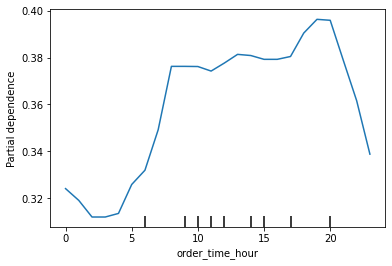

In [73]:
# %%time
# test = PartialDependenceDisplay.from_estimator(regressor, X[:1000], ['order_time_hour'],n_jobs = 6)
# test.pd_results

In [ ]:
# %%time 
# I tried to plot all PDP all at once but seems to trigger memory errors
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# plt.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(figsize=(12,15))
# plt.tight_layout()
# pdp_all_continuous = PartialDependenceDisplay.from_estimator(regressor, X, feature_list_continuous, n_jobs=8, ax=ax)
# plt.subplots_adjust(top=1.2)
# plt.savefig('./output/pdp_all_continuous.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [87]:
# %%time 
# ~50min
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in ['restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
#     'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km','price_per_item','estimated_rent']:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

2024-07-23 16:36:37.573783 *************** Start running PDP: feature_list_continuous ***************
2024-07-23 16:36:37.573929 customer_lon


ValueError: Feature 'customer_lon' not in feature_names

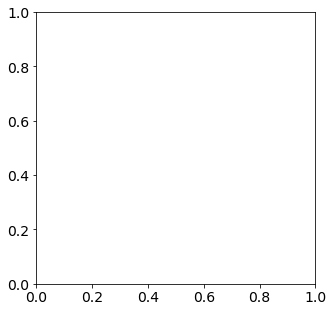

In [80]:
%%time 
# ~5min per PDP graph
# using for loop, otherwise might occur memory errors
# PDP for continuous features and save the graph for each feature separately
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

for feature_one in feature_list_continuous:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
    plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

## 2. PDP for categorical features 


In [ ]:
%%time 
# Wall time: 16min 29s
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_cat ***************')

for feature_one in feature_list_cat:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    tree_disp_all = PartialDependenceDisplay.from_estimator(
        regressor, X, [feature_one], categorical_features=[feature_one], n_jobs=8 , ax=ax)
    plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")    

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_cat ***************')

main_cusine is a huge categorical feature so create a customized graph

In [ ]:
%%time 
# ~ 2min
print(datetime.datetime.now(),'*************** Start running PDP: main_cusine ***************')

feature_select = 'main_cuisine'

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(18,6))
pdp_main_cusine = PartialDependenceDisplay.from_estimator(
    regressor, X, [feature_select], categorical_features=[feature_select], n_jobs=8 ,ax=ax)
plt.savefig('./output/pdp_'+feature_select+'.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: main_cusine ***************')

In [2]:
# print(pdp_main_cusine.bars_[0][0].get_height())
# print(pdp_main_cusine.bars_[0][0].get_x())

# SHAP
"When using CatBoost, you do not need to manually encode categorical features. CatBoost natively handles categorical features, making it unnecessary to apply encoding techniques like one-hot encoding or label encoding. Simply specify the categorical features in the model training process."

In [15]:
# # Using numerical encoding for categorical features so that SHAP beeswarm can color coded high and low values of categorical features
# X_shap = X.copy()
# X_shap.loc[X_shap.rating == '1.Amazing', 'rating'] = 5
# X_shap.loc[X_shap.rating == '2.Very good', 'rating'] = 4
# X_shap.loc[X_shap.rating == '3.Good', 'rating'] = 3
# X_shap.loc[X_shap.rating == '4.OK', 'rating'] = 2
# X_shap.loc[X_shap.rating == '5.None', 'rating'] = 1

# X_shap.loc[X_shap.n_rating == '1.Amazing', 'n_rating'] = 5
# X_shap.loc[X_shap.n_rating == '2.Very good', 'n_rating'] = 4
# X_shap.loc[X_shap.n_rating == '3.Good', 'n_rating'] = 3
# X_shap.loc[X_shap.n_rating == '4.OK', 'n_rating'] = 2
# X_shap.loc[X_shap.n_rating == '5.None', 'n_rating'] = 1


# X_shap.loc[X_shap.isweekend == 'Yes', 'isweekend'] = 1
# X_shap.loc[X_shap.isweekend == 'No', 'isweekend'] = 0

# X_shap.loc[X_shap.incentive_delivery == 'Yes', 'incentive_delivery'] = 1
# X_shap.loc[X_shap.incentive_delivery == 'No', 'incentive_delivery'] = 0

# X_shap.loc[X_shap.incentive_menu_discount == 'Yes', 'incentive_menu_discount'] = 1
# X_shap.loc[X_shap.incentive_menu_discount == 'No', 'incentive_menu_discount'] = 0

# X_shap.loc[X_shap.incentive_voucher_wallet == 'Yes', 'incentive_voucher_wallet'] = 1
# X_shap.loc[X_shap.incentive_voucher_wallet == 'No', 'incentive_voucher_wallet'] = 0
# print(X_shap.shape[0]) #2767286

In [122]:
# %%time
# #  ~4min
# import shap
# print(datetime.datetime.now(),'*************** Start running SHAP ***************')
# explainer = shap.TreeExplainer(regressor)
# shap_values = explainer(X_shap)
# print(datetime.datetime.now(),'*************** Done running SHAP ***************')

In [120]:
# # apply Label Encoding over categorical features
# # https://stackoverflow.com/questions/57285499/how-to-tell-the-shap-tree-explainer-and-shap-values-calculator-which-variables-a
# X_shap = X.copy()
# X_shap['rating'] = X_shap['rating'].astype('category')
# X_shap['rating'] = X_shap['rating'].cat.codes

# X_shap['n_rating'] = X_shap['n_rating'].astype('category')
# X_shap['n_rating'] = X_shap['n_rating'].cat.codes

# X_shap['isweekend'] = X_shap['isweekend'].astype('category')
# X_shap['isweekend'] = X_shap['isweekend'].cat.codes

# X_shap['incentive_delivery'] = X_shap['incentive_delivery'].astype('category')
# X_shap['incentive_delivery'] = X_shap['incentive_delivery'].cat.codes

# X_shap['incentive_menu_discount'] = X_shap['incentive_menu_discount'].astype('category')
# X_shap['incentive_menu_discount'] = X_shap['incentive_menu_discount'].cat.codes

# X_shap['incentive_voucher_wallet'] = X_shap['incentive_voucher_wallet'].astype('category')
# X_shap['incentive_voucher_wallet'] = X_shap['incentive_voucher_wallet'].cat.codes

# # X_shap['main_cuisine'] = X_shap['main_cuisine'].astype('category')
# # X_shap['main_cuisine'] = X_shap['main_cuisine'].cat.codes

# X_shap = X.copy()
# X_shap = pd.get_dummies(X_shap)
# X_shap

In [30]:
%%time
#  ~4min
import shap
print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X)
print(datetime.datetime.now(),'*************** Done running SHAP ***************')

2024-07-30 12:39:57.090227 *************** Start running SHAP ***************
2024-07-30 12:42:31.751334 *************** Done running SHAP ***************
CPU times: user 10min 53s, sys: 17.1 s, total: 11min 10s
Wall time: 2min 43s


In [ ]:
print(df_localness.order_id.unique().shape[0])
df_localness.head(2)

### save SHAP values

In [ ]:
# %%time
# shaplist = ['shap_'+i for i in X.columns]
# df_shape_values = pd.DataFrame(shap_values.values, columns=shaplist)

# df_shape_values['account_id'] = df_localness['account_id']
# df_shape_values['customer_lon'] = df_localness['customer_lon']
# df_shape_values['customer_lat'] = df_localness['customer_lat']

# df_shape_values['vendor_id'] = df_localness['vendor_id']
# df_shape_values['vendor_lon'] = df_localness['vendor_lon']
# df_shape_values['vendor_lat'] = df_localness['vendor_lat']

# df_shape_values['order_id'] = df_localness['order_id']
# first_column = df_shape_values.pop('order_id')
# df_shape_values.insert(0, 'order_id', first_column)
# # df_shape_values
# df_shape_values.to_csv('./output/food_localness_final_oct_shap_values.csv',sep=',',index=False)
# df_shape_values.head()

### SHAP feature importance

2024-07-30 14:57:22.212419 *************** Start running SHAP importance ***************
2024-07-30 14:58:07.037161 *************** Done running SHAP importance ***************
CPU times: user 41.9 s, sys: 2.3 s, total: 44.2 s
Wall time: 44.8 s


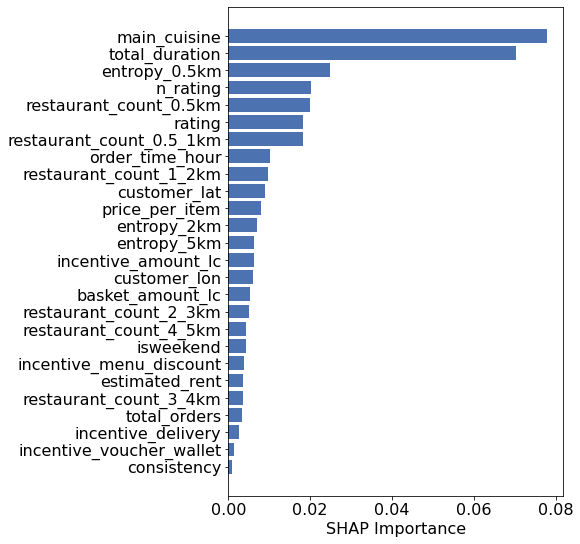

In [33]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('SHAP Importance')
plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

In [32]:
df_shap = pd.DataFrame({
    'col': np.array(X.columns)[sorted_idx],
    'shap': shap_importance[sorted_idx]
})
df_shap.set_index('col', inplace=True)
df_shap = df_shap.T
print('order level', df_shap['basket_amount_lc'] + df_shap['price_per_item'] + df_shap['order_time_hour'] + df_shap['total_duration'] + df_shap['incentive_amount_lc'] + 
      df_shap['incentive_delivery'] + df_shap['incentive_voucher_wallet'] + df_shap['incentive_menu_discount'] + df_shap['isweekend'] 
      + df_shap['n_rating'] + df_shap['rating'] + df_shap['main_cuisine'])
print('user level', df_shap['consistency'] + df_shap['total_orders'] + df_shap['customer_lon'] + df_shap['customer_lat'])
print('neighborhood level', df_shap['estimated_rent'] + df_shap['restaurant_count_3_4km'] + df_shap['restaurant_count_4_5km'] + df_shap['restaurant_count_2_3km'] + 
      df_shap['restaurant_count_1_2km']+ df_shap['entropy_5km']+ df_shap['entropy_2km']+ df_shap['restaurant_count_0.5_1km']+ df_shap['entropy_0.5km'] + 
     df_shap['restaurant_count_0.5km']) 

order level shap   0.22895
dtype: float64
user level shap   0.01903
dtype: float64
neighborhood level shap   0.10262
dtype: float64


In [43]:
# %%time
# # This is the visualization function offered by shap package for feature importance. ~1min
# print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
# #Plot the mean absolute value of the SHAP values
# fig_shapimportance = shap.plots.bar(shap_values, max_display=50,show=False)
# plt.savefig('./output/shap_importance.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

In [ ]:
%%time
# ~6min
# Reading about gray colors: https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm_updated_longlat.pdf', bbox_inches='tight')
# plt.savefig('./output/shap_beeswarm_updated.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running beeswarm ***************')

2024-07-02 15:09:42.530650 *************** Start running beeswarm ***************


## Plot interaction effects between a pair

In [51]:
def plot_shap_interaction(var1, var2):
    fig = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                           interaction_index=var2, show=False) #, ax=ax
    plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

In [52]:
# var_interact1 = 'restaurant_count_0.5km'
var_interact2 = 'entropy_0.5km'
var_interact3 = 'estimated_rent'

feature_list_continuous_for_shap = ['basket_amount_lc','price_per_item','order_time_hour','total_duration',
  'consistency', 'total_orders', 'entropy_2km', 'entropy_5km', 'restaurant_count_0.5km',
  'restaurant_count_0.5_1km', 'restaurant_count_1_2km', 'restaurant_count_2_3km', 'restaurant_count_3_4km',
  'restaurant_count_4_5km']

2024-07-02 16:39:01.089752 basket_amount_lc entropy_0.5km Running!!!
2024-07-02 16:39:22.977929 basket_amount_lc entropy_0.5km Done!!!
2024-07-02 16:39:22.978022 price_per_item entropy_0.5km Running!!!
2024-07-02 16:39:44.710340 price_per_item entropy_0.5km Done!!!
2024-07-02 16:39:44.710430 order_time_hour entropy_0.5km Running!!!
2024-07-02 16:40:05.917379 order_time_hour entropy_0.5km Done!!!
2024-07-02 16:40:05.917475 total_duration entropy_0.5km Running!!!
2024-07-02 16:40:27.077676 total_duration entropy_0.5km Done!!!
2024-07-02 16:40:27.077770 consistency entropy_0.5km Running!!!
2024-07-02 16:40:48.813275 consistency entropy_0.5km Done!!!
2024-07-02 16:40:48.813368 total_orders entropy_0.5km Running!!!
2024-07-02 16:41:09.988055 total_orders entropy_0.5km Done!!!
2024-07-02 16:41:09.988148 entropy_2km entropy_0.5km Running!!!
2024-07-02 16:41:31.838351 entropy_2km entropy_0.5km Done!!!
2024-07-02 16:41:31.838448 entropy_5km entropy_0.5km Running!!!
2024-07-02 16:41:53.697519 en

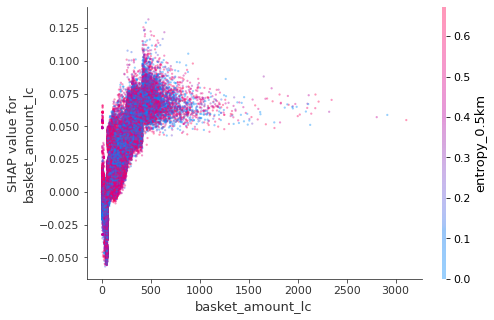

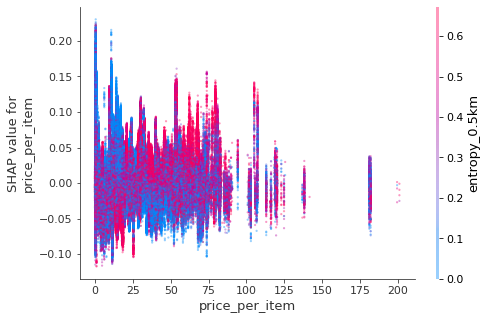

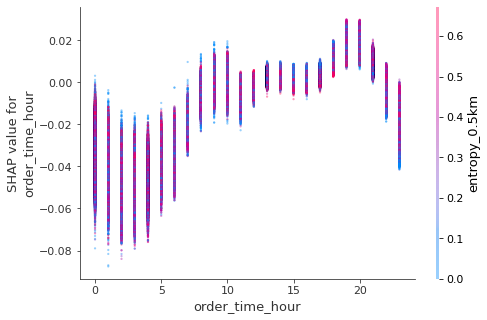

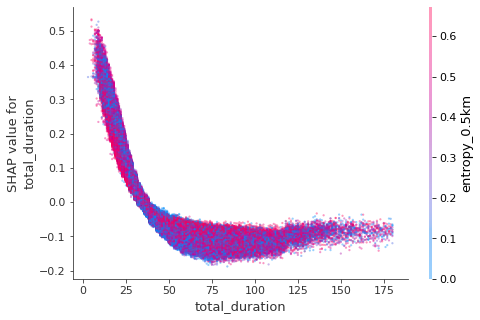

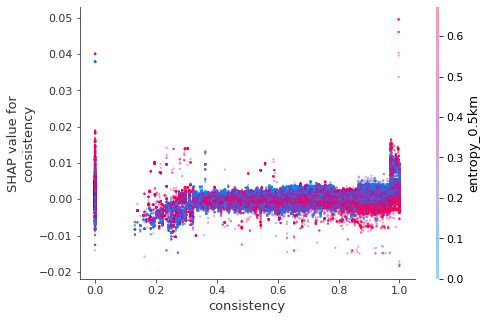

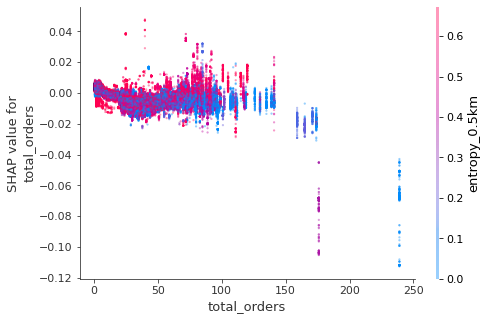

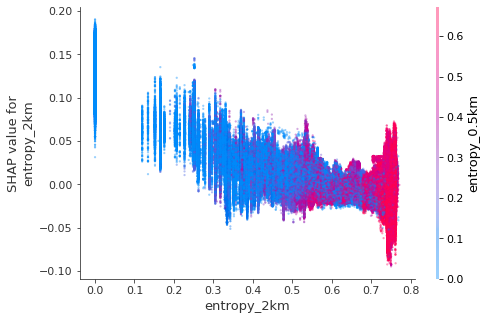

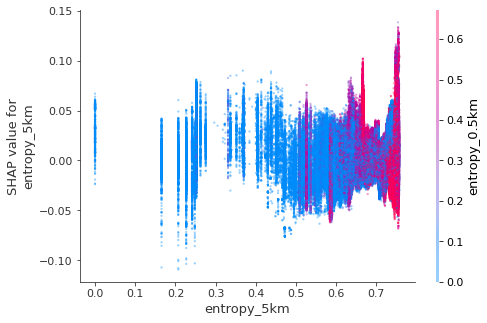

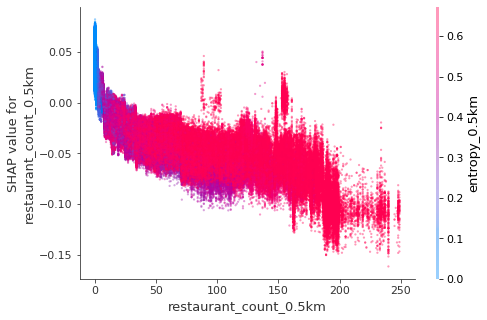

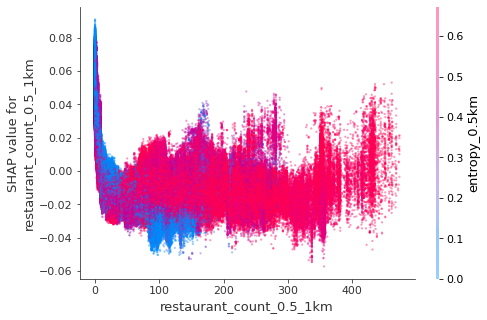

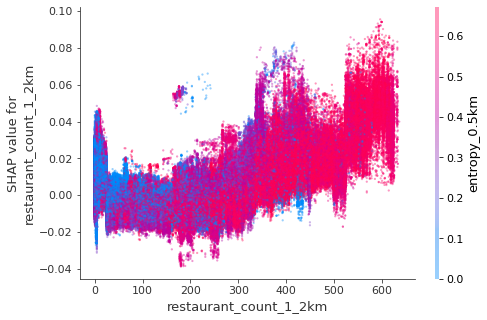

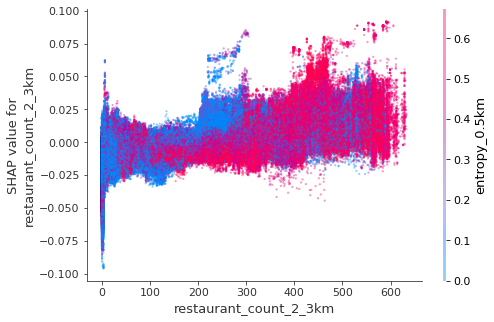

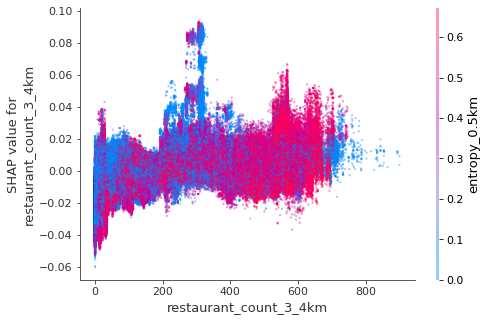

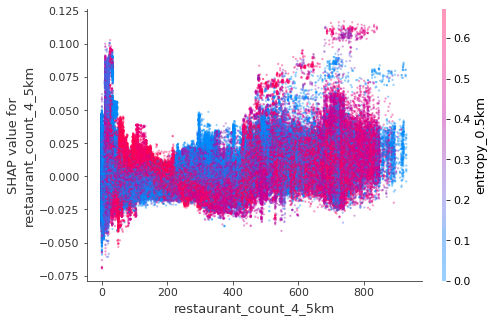

In [53]:
%%time
# ~12min interaction plot with var_interact2 = 'entropy_0.5km'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact2,'Running!!!')
    plot_shap_interaction(var, var_interact2)
    print(datetime.datetime.now(), var, var_interact2,'Done!!!')

2024-07-02 16:45:30.855372 basket_amount_lc estimated_rent Running!!!
2024-07-02 16:45:52.834404 basket_amount_lc estimated_rent Done!!!
2024-07-02 16:45:52.834496 price_per_item estimated_rent Running!!!
2024-07-02 16:46:13.939834 price_per_item estimated_rent Done!!!
2024-07-02 16:46:13.939943 order_time_hour estimated_rent Running!!!
2024-07-02 16:46:34.357148 order_time_hour estimated_rent Done!!!
2024-07-02 16:46:34.357238 total_duration estimated_rent Running!!!
2024-07-02 16:46:54.775788 total_duration estimated_rent Done!!!
2024-07-02 16:46:54.775879 consistency estimated_rent Running!!!
2024-07-02 16:47:15.898440 consistency estimated_rent Done!!!
2024-07-02 16:47:15.898548 total_orders estimated_rent Running!!!
2024-07-02 16:47:36.474549 total_orders estimated_rent Done!!!
2024-07-02 16:47:36.474640 entropy_2km estimated_rent Running!!!
2024-07-02 16:47:57.558382 entropy_2km estimated_rent Done!!!
2024-07-02 16:47:57.558473 entropy_5km estimated_rent Running!!!
2024-07-02 16:

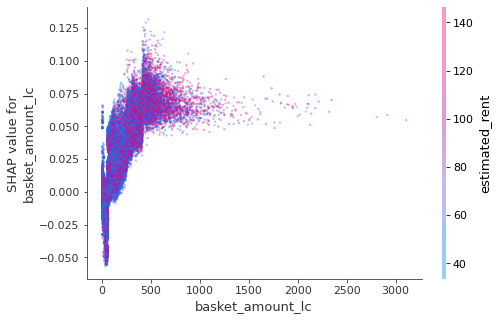

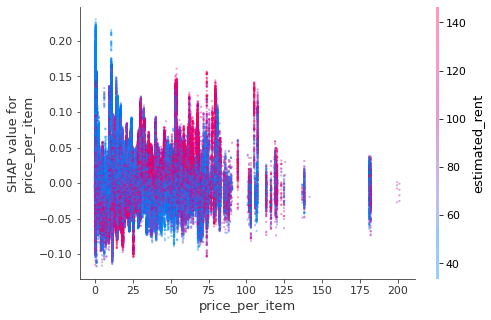

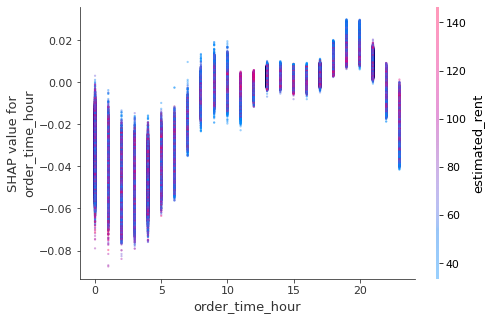

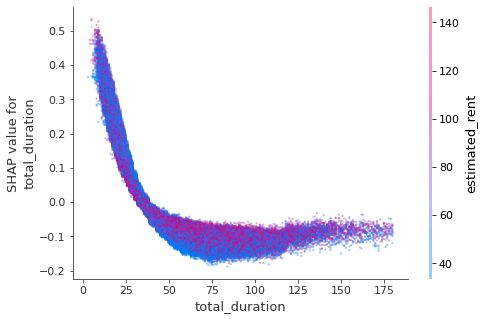

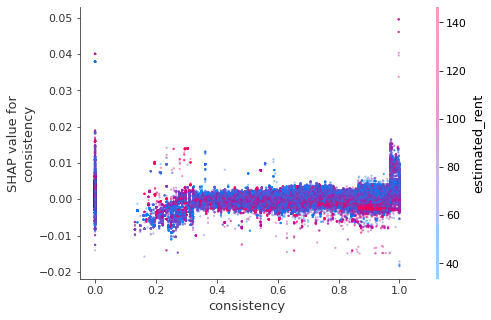

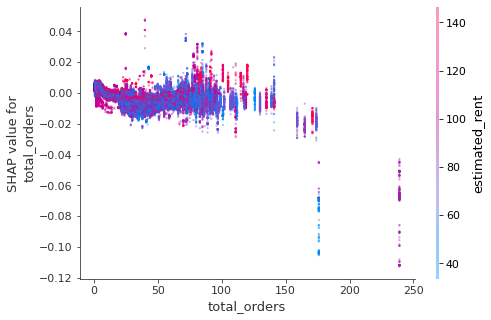

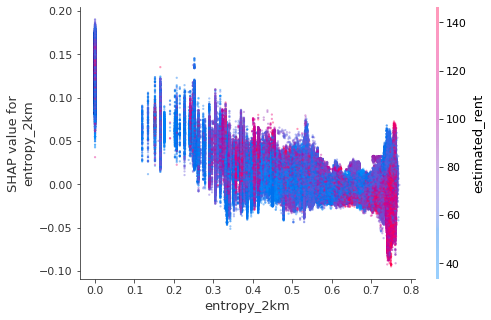

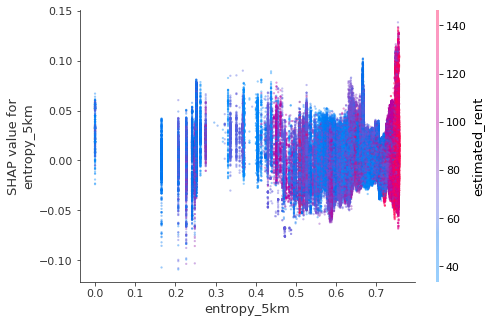

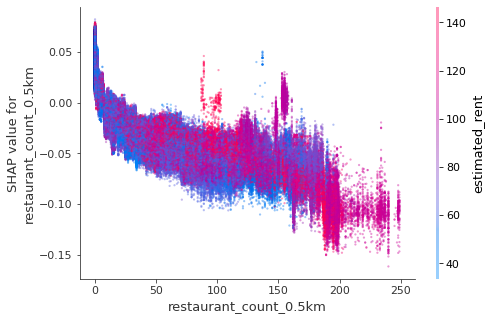

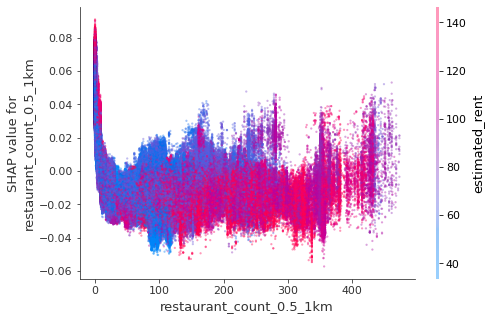

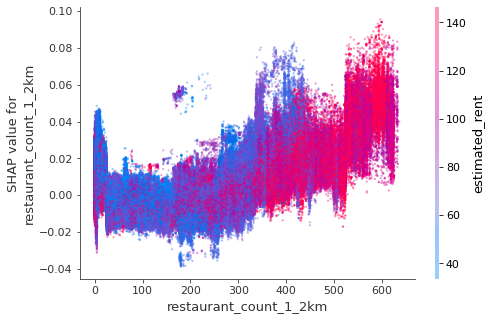

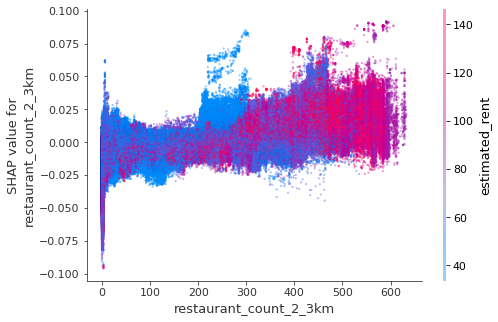

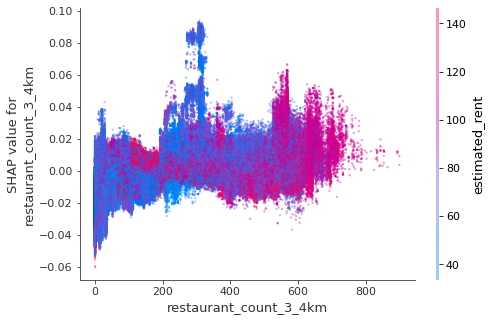

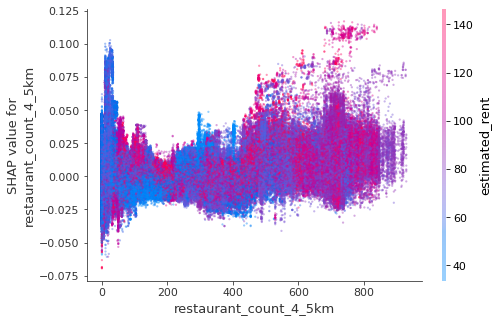

In [54]:
%%time
# ~12min interaction plot with var_interact3 = 'estimated_rent'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact3,'Running!!!')
    plot_shap_interaction(var, var_interact3)
    print(datetime.datetime.now(), var, var_interact3,'Done!!!')

In [55]:
# %%time
# # ~12min interaction plot with var_interact1 = 'restaurant_count_0.5km'
# for var in feature_list_continuous_for_shap:
#     print(datetime.datetime.now(), var, var_interact1,'Running!!!')
#     plot_shap_interaction(var, var_interact1)
#     print(datetime.datetime.now(), var, var_interact1,'Done!!!')

In [ ]:
%%time

#for incentive we use this function because we need to modify the x axis range
def plot_shap_interaction_incentives(var1, x_jitter1=0):
    for var2 in [var_interact2, var_interact3]: #var_interact1
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.xlim(xmin=0,xmax=30)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')    
        
# set a x limit for incentive plots if needed, cancel the comment line in function plot_shap_interaction_onevar()
plot_shap_interaction_incentives('incentive_amount_lc')

In [ ]:
# this function is for those categorical features that we need to add a bit jitter to prevent overlapping points
def plot_shap_interaction_onevar(var1, x_jitter1=0):
    for var2 in [var_interact2, var_interact3]: #var_interact1
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

print(feature_list_cat)

In [ ]:
%%time
plot_shap_interaction_onevar('rating',x_jitter1=1)
plot_shap_interaction_onevar('n_rating',x_jitter1=1)
# plot_shap_interaction_onevar('order_time_hour',x_jitter1=1)
plot_shap_interaction_onevar('incentive_delivery',x_jitter1=1)
plot_shap_interaction_onevar('incentive_menu_discount',x_jitter1=1)
plot_shap_interaction_onevar('incentive_voucher_wallet',x_jitter1=1)
plot_shap_interaction_onevar('isweekend',x_jitter1=1)

# SHAP interation plots

In [ ]:
%%time
# may take a very long time
shap_interaction = explainer.shap_interaction_values(X)

## (Optional step) Most important interaction effects

In [ ]:
%%time
shap.dependence_plot(0, shap_values.values, X)
# interaction_index“auto”, pick the strongest interaction
# basket amount has a bigger effect on shorter duration orders than on longer duration orders

In [ ]:
%%time
shap.dependence_plot(1, shap_values.values, X)